In [1]:
# Robot Path-Finding using A* Algorithm
# Siddharth. S, ch.sc.u4cse24145

import random, math, time
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import pandas as pd

# Node structure
class Node:
    def __init__(self, f, g, pos, parent):
        self.f = f
        self.g = g
        self.pos = pos
        self.parent = parent
    def __lt__(self, other): return self.f < other.f

# Generate grid
def generate_grid(rows, cols, obstacle_prob):
    grid = [[0 if random.random() > obstacle_prob else 1 for _ in range(cols)] for _ in range(rows)]
    return grid

def random_free_cell(grid):
    rows, cols = len(grid), len(grid[0])
    while True:
        r, c = random.randrange(rows), random.randrange(cols)
        if grid[r][c] == 0: return (r, c)

# Heuristics
def manhattan(a, b): return abs(a[0] - b[0]) + abs(a[1] - b[1])
def euclidean(a, b): return math.hypot(a[0] - b[0], a[1] - b[1])
def chebyshev(a, b): return max(abs(a[0] - b[0]), abs(a[1] - b[1]))
def zero(a, b): return 0

# A* Search
def astar(grid, start, goal, heuristic):
    rows, cols = len(grid), len(grid[0])
    dirs = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    open_list = []
    heappush(open_list, Node(heuristic(start, goal), 0, start, None))
    g_score = {start: 0}
    closed = set()
    nodes_expanded = 0
    start_time = time.time()

    while open_list:
        node = heappop(open_list)
        nodes_expanded += 1
        if node.pos == goal:
            path = []
            while node:
                path.append(node.pos)
                node = node.parent
            return True, path[::-1], nodes_expanded, time.time() - start_time
        closed.add(node.pos)
        for dr, dc in dirs:
            r, c = node.pos[0]+dr, node.pos[1]+dc
            if not (0 <= r < rows and 0 <= c < cols): continue
            if grid[r][c] == 1: continue
            new_g = g_score[node.pos] + (math.hypot(dr, dc))
            if (r,c) in closed and new_g >= g_score.get((r,c), float('inf')): continue
            if new_g < g_score.get((r,c), float('inf')):
                g_score[(r,c)] = new_g
                f = new_g + heuristic((r,c), goal)
                heappush(open_list, Node(f, new_g, (r,c), node))

    return False, [], nodes_expanded, time.time() - start_time

# Run experiments
def run_experiments(trials=40, size=(30,30), obstacle_prob=0.2):
    heuristics = {"Manhattan": manhattan, "Euclidean": euclidean, "Chebyshev": chebyshev, "Zero": zero}
    records = []
    for t in range(trials):
        grid = generate_grid(*size, obstacle_prob)
        start, goal = random_free_cell(grid), random_free_cell(grid)
        for name, h in heuristics.items():
            found, path, nodes, runtime = astar(grid, start, goal, h)
            records.append({"trial": t, "heuristic": name, "found": found,
                            "nodes_expanded": nodes, "time": runtime,
                            "path_length": len(path) if found else None})
    df = pd.DataFrame(records)
    df.groupby("heuristic").mean().to_csv("astar_summary.csv")
    df.to_csv("astar_raw.csv", index=False)
    return df

if __name__ == "__main__":
    df = run_experiments()
    print(df.groupby("heuristic").mean())


           trial  found  nodes_expanded      time  path_length
heuristic                                                     
Chebyshev   19.5    1.0           78.35  0.001174       12.825
Euclidean   19.5    1.0           44.45  0.000829       12.825
Manhattan   19.5    1.0           18.65  0.000310       13.000
Zero        19.5    1.0          323.50  0.004428       12.825


Demonstrating A* Search with Manhattan Distance
Start: (9, 5)
Goal: (10, 0)
Path found: True
Path length: 6
Nodes expanded: 8


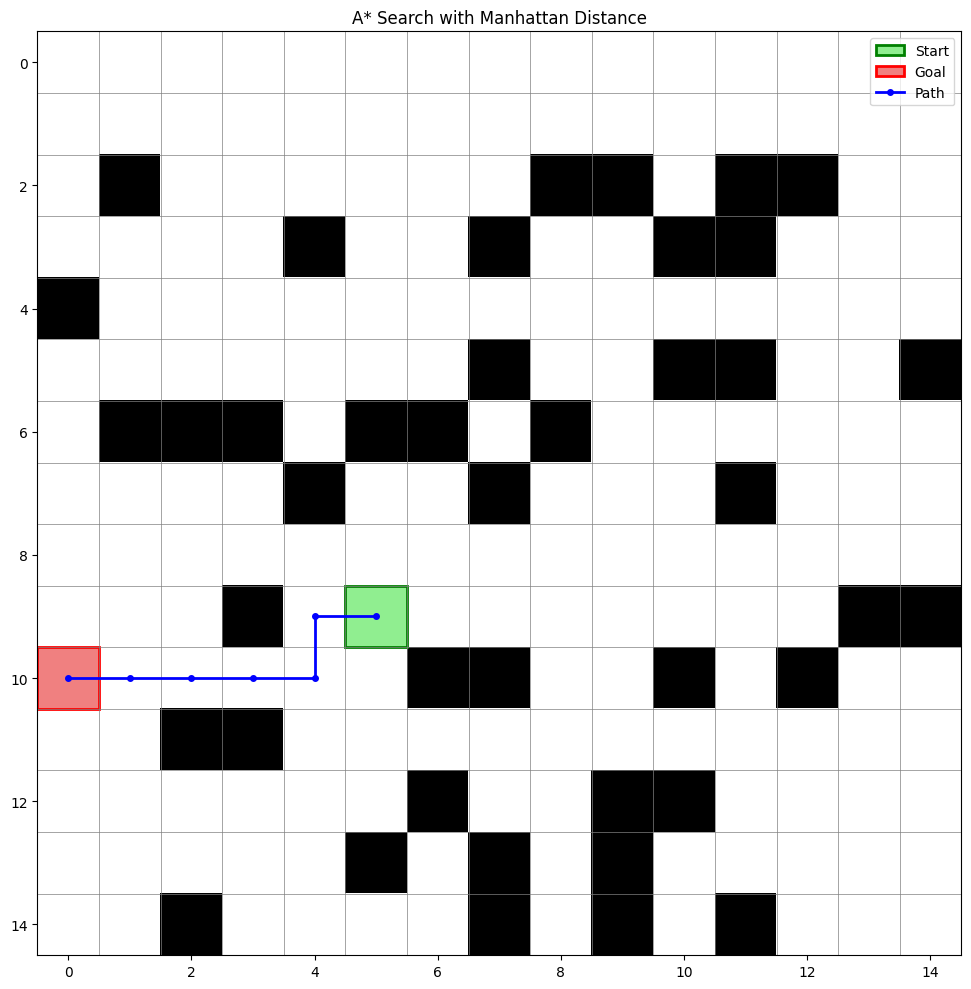


Running experiments with multiple heuristics...
Running trial 1/100
Running trial 2/100
Running trial 3/100
Running trial 4/100
Running trial 5/100
Running trial 6/100
Running trial 7/100
Running trial 8/100
Running trial 9/100
Running trial 10/100
Running trial 11/100
Running trial 12/100
Running trial 13/100
Running trial 14/100
Running trial 15/100
Running trial 16/100
Running trial 17/100
Running trial 18/100
Running trial 19/100
Running trial 20/100
Running trial 21/100
Running trial 22/100
Running trial 23/100
Running trial 24/100
Running trial 25/100
Running trial 26/100
Running trial 27/100
Running trial 28/100
Running trial 29/100
Running trial 30/100
Running trial 31/100
Running trial 32/100
Running trial 33/100
Running trial 34/100
Running trial 35/100
Running trial 36/100
Running trial 37/100
Running trial 38/100
Running trial 39/100
Running trial 40/100
Running trial 41/100
Running trial 42/100
Running trial 43/100
Running trial 44/100
Running trial 45/100
Running trial 4

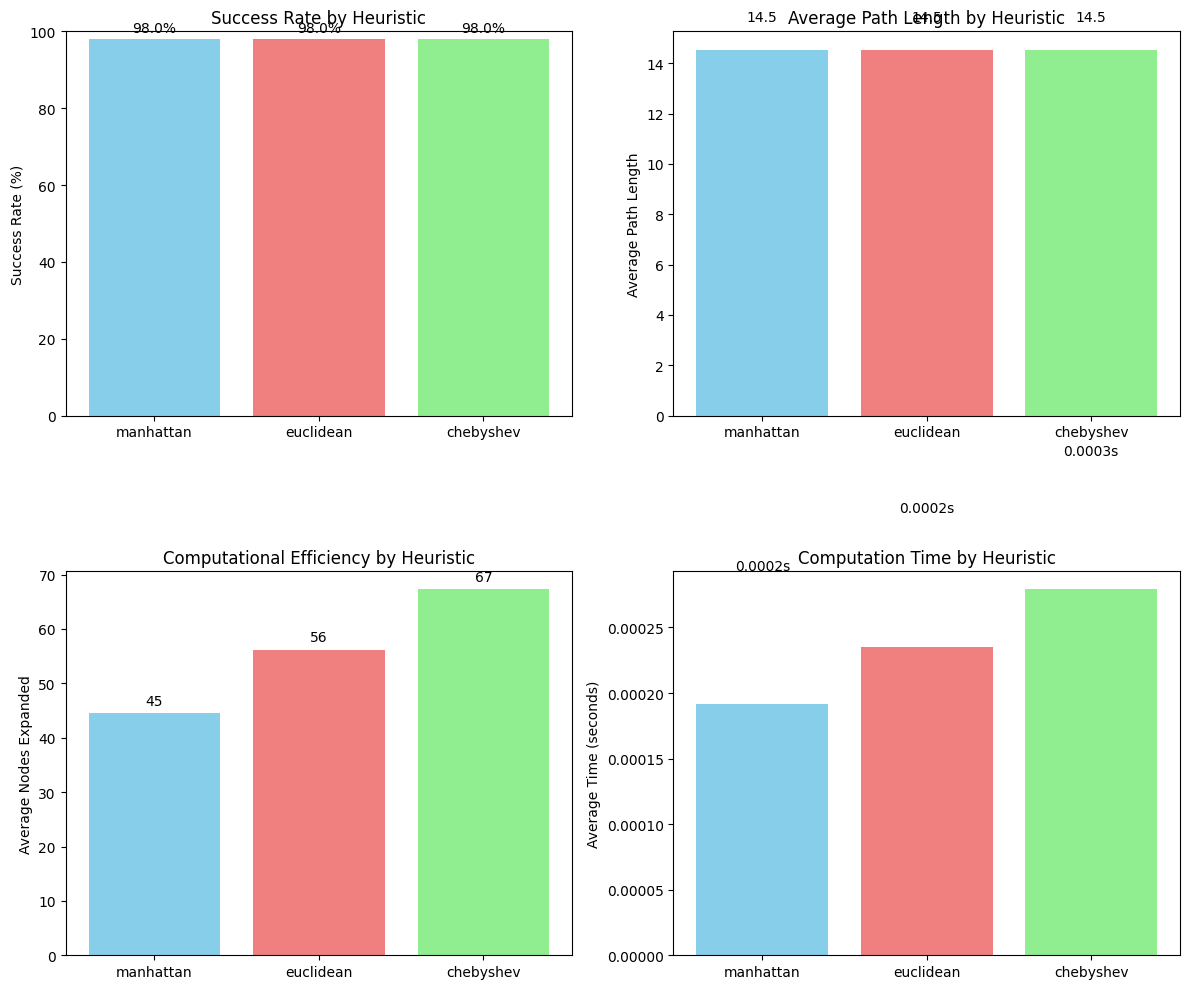

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import heapq
import time
import random
from collections import defaultdict

class GridWorld:
    def __init__(self, width=20, height=20, obstacle_density=0.2):
        self.width = width
        self.height = height
        self.obstacle_density = obstacle_density
        self.grid = None
        self.start = None
        self.goal = None
        self.generate_grid()

    def generate_grid(self):
        # Create empty grid (0 = free, 1 = obstacle)
        self.grid = np.zeros((self.height, self.width), dtype=int)

        # Add random obstacles
        for i in range(self.height):
            for j in range(self.width):
                if random.random() < self.obstacle_density:
                    self.grid[i][j] = 1

        # Generate random start and goal positions
        while True:
            self.start = (random.randint(0, self.height-1), random.randint(0, self.width-1))
            self.goal = (random.randint(0, self.height-1), random.randint(0, self.width-1))

            # Ensure start and goal are not obstacles and are different positions
            if (self.grid[self.start[0]][self.start[1]] == 0 and
                self.grid[self.goal[0]][self.goal[1]] == 0 and
                self.start != self.goal):
                break

    def is_valid_position(self, pos):
        x, y = pos
        return (0 <= x < self.height and 0 <= y < self.width and
                self.grid[x][y] == 0)

class AStarSolver:
    def __init__(self, grid_world):
        self.grid_world = grid_world
        self.moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    def manhattan_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def euclidean_distance(self, pos1, pos2):
        return ((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)**0.5

    def chebyshev_distance(self, pos1, pos2):
        return max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1]))

    def solve(self, heuristic_name='manhattan'):
        start = self.grid_world.start
        goal = self.grid_world.goal

        # Select heuristic function
        if heuristic_name == 'manhattan':
            heuristic = self.manhattan_distance
        elif heuristic_name == 'euclidean':
            heuristic = self.euclidean_distance
        elif heuristic_name == 'chebyshev':
            heuristic = self.chebyshev_distance
        else:
            raise ValueError("Unknown heuristic")

        # Priority queue: (f_score, g_score, position, path)
        open_set = []
        heapq.heappush(open_set, (heuristic(start, goal), 0, start, [start]))

        # Keep track of visited positions and their g_scores
        g_scores = {start: 0}
        visited = set()
        nodes_expanded = 0

        while open_set:
            current_f, current_g, current_pos, current_path = heapq.heappop(open_set)

            if current_pos in visited:
                continue

            visited.add(current_pos)
            nodes_expanded += 1

            # Check if we reached the goal
            if current_pos == goal:
                return {
                    'path': current_path,
                    'path_length': len(current_path) - 1,
                    'nodes_expanded': nodes_expanded,
                    'success': True
                }

            # Explore neighbors
            for move in self.moves:
                neighbor = (current_pos[0] + move[0], current_pos[1] + move[1])

                if (self.grid_world.is_valid_position(neighbor) and
                    neighbor not in visited):

                    new_g = current_g + 1  # All moves cost 1

                    # If we found a better path to this neighbor
                    if neighbor not in g_scores or new_g < g_scores[neighbor]:
                        g_scores[neighbor] = new_g
                        f_score = new_g + heuristic(neighbor, goal)
                        new_path = current_path + [neighbor]
                        heapq.heappush(open_set, (f_score, new_g, neighbor, new_path))

        # No path found
        return {
            'path': [],
            'path_length': float('inf'),
            'nodes_expanded': nodes_expanded,
            'success': False
        }

def visualize_grid(grid_world, path=None, title="Grid World"):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Create colormap: 0=white (free), 1=black (obstacle)
    cmap = plt.cm.colors.ListedColormap(['white', 'black'])
    bounds = [0, 0.5, 1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Display grid
    ax.imshow(grid_world.grid, cmap=cmap, norm=norm)

    # Draw grid lines
    ax.set_xticks(np.arange(-0.5, grid_world.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_world.height, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)

    # Mark start and goal
    start_rect = patches.Rectangle((grid_world.start[1]-0.5, grid_world.start[0]-0.5),
                                  1, 1, linewidth=2, edgecolor='green', facecolor='lightgreen', label='Start')
    goal_rect = patches.Rectangle((grid_world.goal[1]-0.5, grid_world.goal[0]-0.5),
                                 1, 1, linewidth=2, edgecolor='red', facecolor='lightcoral', label='Goal')
    ax.add_patch(start_rect)
    ax.add_patch(goal_rect)

    # Draw path if available
    if path:
        path_x = [pos[1] for pos in path]
        path_y = [pos[0] for pos in path]
        ax.plot(path_x, path_y, color='blue', linewidth=2, marker='o', markersize=4, label='Path')

    ax.set_xlim(-0.5, grid_world.width-0.5)
    ax.set_ylim(grid_world.height-0.5, -0.5)
    ax.set_title(title)
    ax.legend()

    plt.tight_layout()
    plt.show()

def run_experiments(num_trials=50, grid_size=20, obstacle_density=0.2):
    heuristics = ['manhattan', 'euclidean', 'chebyshev']
    results = {h: {'success_rate': 0, 'path_lengths': [], 'nodes_expanded': [], 'computation_time': []}
               for h in heuristics}

    for trial in range(num_trials):
        print(f"Running trial {trial+1}/{num_trials}")
        grid_world = GridWorld(width=grid_size, height=grid_size, obstacle_density=obstacle_density)

        for heuristic in heuristics:
            solver = AStarSolver(grid_world)

            start_time = time.time()
            result = solver.solve(heuristic)
            end_time = time.time()

            computation_time = end_time - start_time

            if result['success']:
                results[heuristic]['success_rate'] += 1
                results[heuristic]['path_lengths'].append(result['path_length'])
                results[heuristic]['nodes_expanded'].append(result['nodes_expanded'])
                results[heuristic]['computation_time'].append(computation_time)
            else:
                # For failed paths, use maximum values
                results[heuristic]['path_lengths'].append(float('inf'))
                results[heuristic]['nodes_expanded'].append(float('inf'))
                results[heuristic]['computation_time'].append(computation_time)

    # Calculate averages and success rates
    for heuristic in heuristics:
        results[heuristic]['success_rate'] = results[heuristic]['success_rate'] / num_trials * 100

        # Calculate averages excluding failed paths
        successful_paths = [length for length in results[heuristic]['path_lengths'] if length != float('inf')]
        results[heuristic]['avg_path_length'] = np.mean(successful_paths) if successful_paths else float('inf')

        successful_nodes = [nodes for nodes in results[heuristic]['nodes_expanded'] if nodes != float('inf')]
        results[heuristic]['avg_nodes_expanded'] = np.mean(successful_nodes) if successful_nodes else float('inf')

        results[heuristic]['avg_computation_time'] = np.mean(results[heuristic]['computation_time'])

    return results

def plot_comparison(results):
    heuristics = list(results.keys())

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Success Rate
    success_rates = [results[h]['success_rate'] for h in heuristics]
    bars1 = ax1.bar(heuristics, success_rates, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Success Rate by Heuristic')
    ax1.set_ylim(0, 100)
    for bar, rate in zip(bars1, success_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom')

    # Average Path Length (only for successful paths)
    avg_path_lengths = [results[h]['avg_path_length'] for h in heuristics]
    valid_lengths = [length for length in avg_path_lengths if length != float('inf')]
    if valid_lengths:
        bars2 = ax2.bar(heuristics, avg_path_lengths, color=['skyblue', 'lightcoral', 'lightgreen'])
        ax2.set_ylabel('Average Path Length')
        ax2.set_title('Average Path Length by Heuristic')
        for bar, length in zip(bars2, avg_path_lengths):
            if length != float('inf'):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{length:.1f}', ha='center', va='bottom')

    # Average Nodes Expanded
    avg_nodes = [results[h]['avg_nodes_expanded'] for h in heuristics]
    valid_nodes = [nodes for nodes in avg_nodes if nodes != float('inf')]
    if valid_nodes:
        bars3 = ax3.bar(heuristics, avg_nodes, color=['skyblue', 'lightcoral', 'lightgreen'])
        ax3.set_ylabel('Average Nodes Expanded')
        ax3.set_title('Computational Efficiency by Heuristic')
        for bar, nodes in zip(bars3, avg_nodes):
            if nodes != float('inf'):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{nodes:.0f}', ha='center', va='bottom')

    # Average Computation Time
    avg_times = [results[h]['avg_computation_time'] for h in heuristics]
    bars4 = ax4.bar(heuristics, avg_times, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax4.set_ylabel('Average Time (seconds)')
    ax4.set_title('Computation Time by Heuristic')
    for bar, time_val in zip(bars4, avg_times):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                f'{time_val:.4f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def demonstrate_single_run():
    print("Demonstrating A* Search with Manhattan Distance")
    grid_world = GridWorld(width=15, height=15, obstacle_density=0.2)
    solver = AStarSolver(grid_world)

    # Solve with Manhattan distance
    result = solver.solve('manhattan')

    print(f"Start: {grid_world.start}")
    print(f"Goal: {grid_world.goal}")
    print(f"Path found: {result['success']}")
    print(f"Path length: {result['path_length']}")
    print(f"Nodes expanded: {result['nodes_expanded']}")

    visualize_grid(grid_world, result['path'], "A* Search with Manhattan Distance")

if __name__ == "__main__":
    # Demonstrate a single run
    demonstrate_single_run()

    # Run experiments
    print("\nRunning experiments with multiple heuristics...")
    results = run_experiments(num_trials=100, grid_size=20, obstacle_density=0.2)

    # Print results
    print("\n=== EXPERIMENTAL RESULTS ===")
    for heuristic, data in results.items():
        print(f"\n{heuristic.upper()} HEURISTIC:")
        print(f"  Success Rate: {data['success_rate']:.1f}%")
        print(f"  Average Path Length: {data['avg_path_length']:.2f}")
        print(f"  Average Nodes Expanded: {data['avg_nodes_expanded']:.2f}")
        print(f"  Average Computation Time: {data['avg_computation_time']:.6f} seconds")

    # Plot comparison
    plot_comparison(results)